# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 會需要一點時間
# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

In [3]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import convert_to_openai_messages, HumanMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages.utils import trim_messages
from langchain_core.messages.utils import count_tokens_approximately


class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State, config: RunnableConfig):
  # 💻code below:
  # hint: you can use langchain_core trim_messages function to trim your trim_messages, and count_tokens_approximately to count tokens
  """
  主要處理chatbot回應的邏輯
  這裡僅單純將使用者的對話紀錄(傳入的state中的messages)，送入模型產生回應
  """

   # Convert LangChain messages into OpenAI message dicts.
  system_prompt = "你是個只能使用繁體中文回答的助理，且你只需要針對問題'簡答'，像個人在對話"
  max_prompt_tokens = 512
  trimmed_messages = trim_messages(
      messages=state["messages"],
      max_tokens=max_prompt_tokens,
      token_counter=count_tokens_approximately
  )
  messages = convert_to_openai_messages(trimmed_messages)
  mes = [{"role": "system", "content": system_prompt}] + messages
  prompt = tokenizer.apply_chat_template(
      mes,
      tokenize=False,
      add_generation_prompt=True
  )


  response = llm.invoke(prompt)
  return {"messages": [AIMessage(content=response)]}


# 建立graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入短期記憶
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

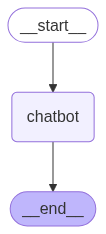

In [5]:
# 看一下graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [6]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
      if "chatbot" in event:
        for value in event.values():
          print("Assistant:", value["messages"][-1].content)

In [7]:
# 設定對話config (第一次對話)
config = {"configurable": {"thread_id": "conversation_1"}} # thread_id: 對話id

In [8]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 我喜歡健身


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Assistant: 健身是一種健康的生活方式，可以增強身體素質、提高免疫力、改善心情，以及保持體態。每天花一些時間健身，可以有效地預防疾病，保持身心平衡。
User: 我叫
Assistant: 你好，很高兴能与你交流。请问有什么问题我可以帮助你解决？
User: 我叫jame
Assistant: 你好，Jame。请问你有什么问题需要我的帮助吗？
User: 請我的的興趣是什麼？
Assistant: 你好，Jame。你个人的兴趣取决于你的性格、经验和兴趣爱好。根据我的理解，你喜欢健身，这可能表明你喜欢运动、健身和保持健康。你可能还有其他兴趣，例如：

1. 运动：足球、籃球、游泳等。
2. 艺术：繪畫、书法、音乐等。
3. 科学：物理、化学、天文等。
4. 社区服務：志愿者、公益活动等。

请告诉我，你还有什么兴趣，我会根据你的兴趣给你推荐一些相关资讯或活动。
User: q
Goodbye!


---

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [ ]:
%%capture --no-stderr
!pip install langchain_core

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver # within-thread memory
from langgraph.store.memory import InMemoryStore # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(__________):
  # 💻code here:
  # TODO:
  # 依據user_id取得長期記憶
  # 將長期記憶也放進system prompt中，讓llm可以個人化回覆


  return {"messages": [AIMessage(content=response)]}


def write_memory(________):
  # 💻code here:
  # TODO:
  # 將使用者的對話整理成要儲存成長期記憶的資訊，並存入長期記憶

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)


# Compile the graph with the checkpointer fir and store

# 💻Code Here
# 記得放入短期記憶，長期記憶的store
graph = builder.compile(checkpointer=______, store=________)


In [ ]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [ ]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [ ]:
# 使用者A的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

In [ ]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_a"}}

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [ ]:
# 💻code here, enjoy the ride 😎
